# EIT-CEM - Background Experimental Data

In [1]:
#Fixing paths
import sys
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list

#Importing modules
from FEIT_onefile import *
from math import pi
import scipy
%matplotlib inline
import time
import seaborn as sns
sns.set_context("talk")

## Mesh

In [2]:
"Definições Básicas do espaço."
r=14            #Radi
L=16           #Number of Electrodes
per_cober=0.454728409  #Perc. area of elec. on boundary
rotate=pi/2-0.0892857143183109       #Rotation

ele_pos=electrodes_position(L, per_cober, rotate, anticlockwise=False) #Eletrodes position object

## Checking electrode dimension

In [3]:
i=0
thetai=(ele_pos.position[i][0])
thetaf=(ele_pos.position[i][1])
elec_lenght=(thetaf-thetai)*r
print("Electrode {} lenght is: {} cm".format(i, elec_lenght))

Electrode 0 lenght is: 2.500000000912705 cm


Number of cells:  1200


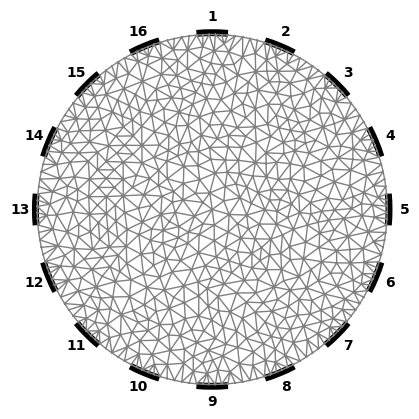

In [4]:
#input
refine_n=15 #Refinement parameter
n_in=6   #Number of vertex on electrodes
n_out=4   #Number of vertex on gaps

mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)
plot_electrodes(mesh, figsize=(5,5), fontsize=10)
print("Number of cells: ", mesh.num_cells())


## Preparing data

In [31]:
#Load experimental data
dataname = "datamat/datamat_1_0.mat" #Background Data
mat = scipy.io.loadmat(dataname)
Uel=mat.get("Uel").T
CP=mat.get("CurrentPattern").T

In [32]:
#Selecting Potentials
Uel_f=Uel[64:] #Matrix of measuarements
Uel_converted=np.zeros_like(Uel_f)

#Convert type of data
for index, potential in enumerate(Uel_f): 
    Uel_converted[index]=ConvertingData(potential, method="KIT4")
list_U0=Uel_converted.flatten() #Matrix to vector

#Current
I_all=CP[64:]/sqrt(2)
l=np.shape(I_all)[0] #Number of experiments = 15

#Noise Estiamtive
delta = EstimateDelta(list_U0, I_all)
print(delta)
noise_level_exp = delta/np.linalg.norm(list_U0)*100
print("Noise level (%): ", noise_level_exp)

0.031426853917333596
Noise level (%):  0.44266934099022376


### Visualizing experimental potentials

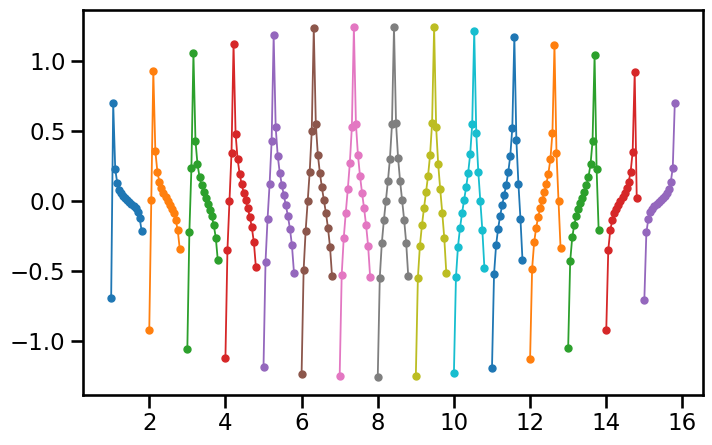

In [7]:
list_U0_m=list_U0.reshape(l,L)
fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(list_U0_m)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);

### Simulating data with $z\approx 0$ and $\gamma=1$

In [8]:
#Definiing background data
Q_DG = FunctionSpace(mesh, "DG", 0)
gamma = Function(Q_DG)
gamma.vector()[:]=np.ones(mesh.num_cells())*1

z_1=np.ones(L)*1E-3
ForwardObject=ForwardProblem(mesh,  z_1)
VD=FiniteElement('CG',mesh.ufl_cell(),1) #Solution Space Continous Galerkin
list_u_1, list_U_1 = ForwardObject.solve_forward(VD, I_all, gamma)


#### Visualizing Potentials $U$

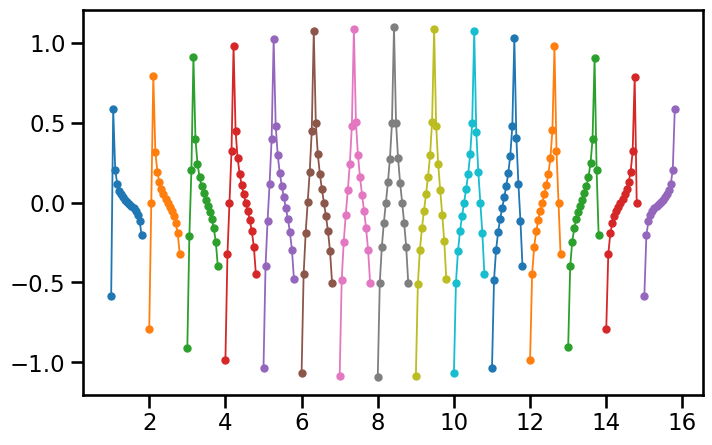

In [9]:
list_U_m_1=np.array(list_U_1).reshape(l,L)
fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(list_U_m_1)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);

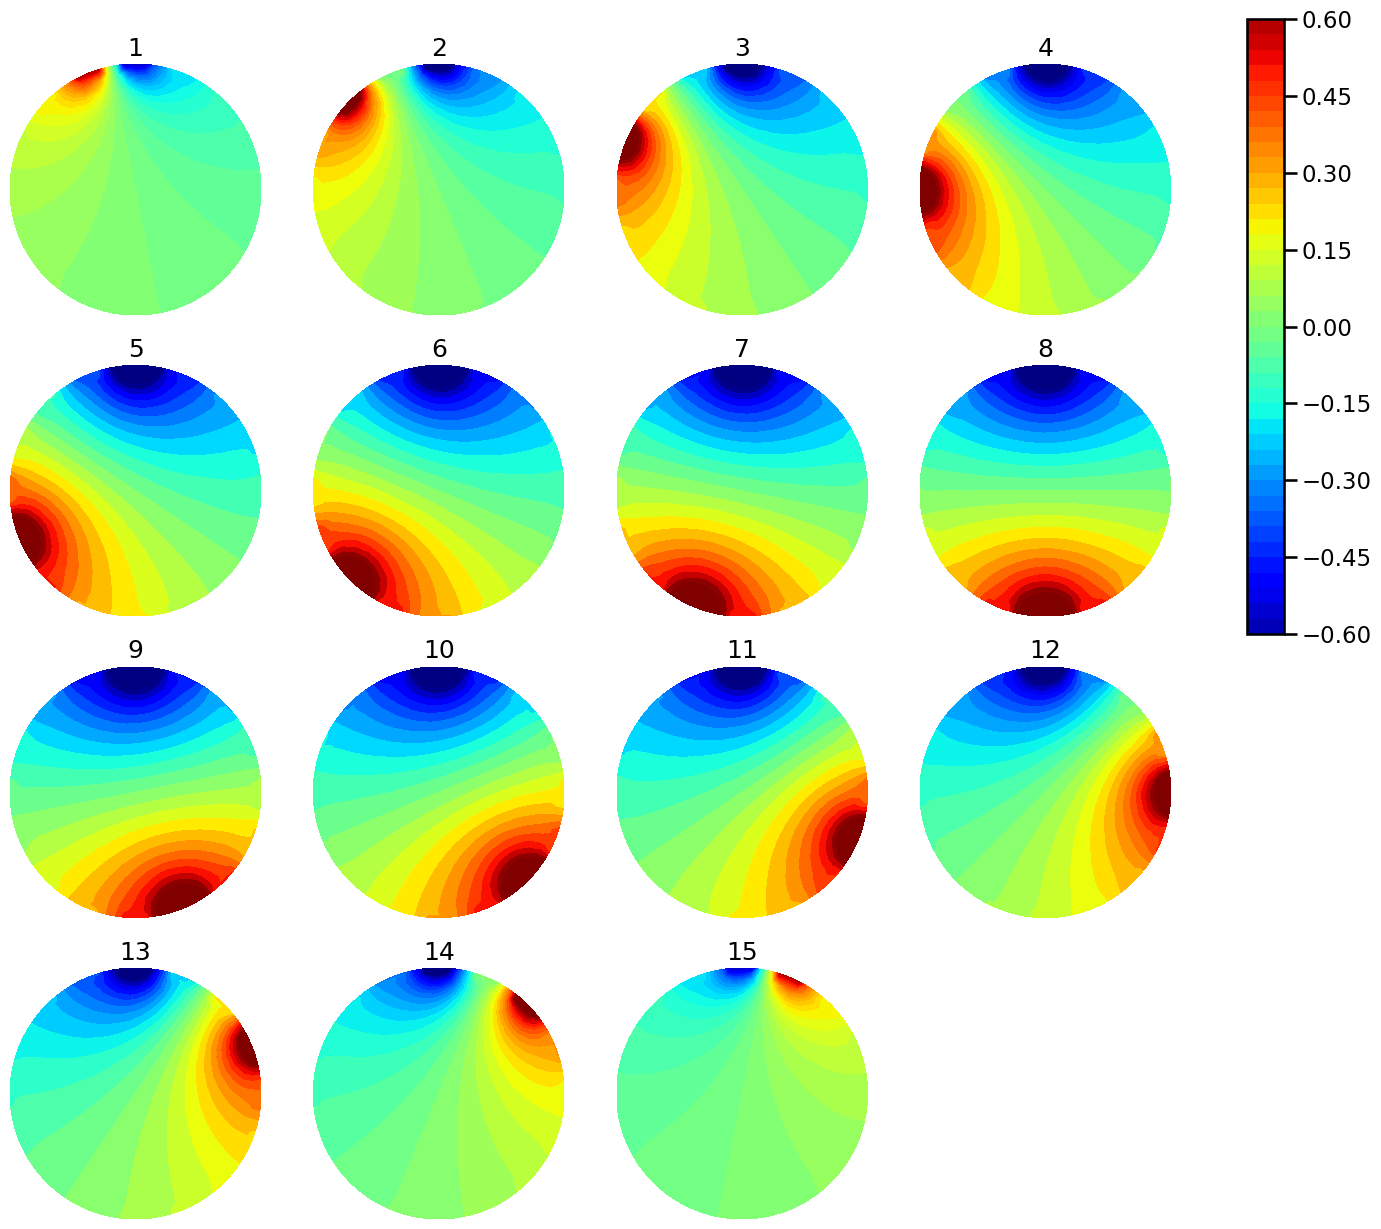

In [10]:
fig = plt.figure(figsize=(15,15))
for i,u in enumerate(list_u_1,1):
    plt.subplot(4,4,i)
    p = plot(u, title=i)
    p.set_cmap("jet")
    p.set_clim(-0.65,0.65)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)

cbar_ax = fig.add_axes([0.95,0.5,0.025,0.41])
fig.colorbar(p, cax=cbar_ax, orientation="vertical")

## Estimating Conductivity $\gamma$

### Method Continuous

In [11]:
#Estime cond
z=np.ones(L)*1E-3
cond= EstimateCond(list_U0, I_all, mesh, z, method="CONT") #Simple method
print("gamma = {:.5f} ".format(cond))

#Verify sol
ForwardObject=ForwardProblem(mesh,  z)
gamma.vector()[:]=np.ones(mesh.num_cells())*cond
_, list_U_Cont = ForwardObject.solve_forward(VD, I_all, gamma)
list_U_Cont=np.array(list_U_Cont).flatten()

res=np.linalg.norm(list_U0-list_U_Cont)/np.linalg.norm(list_U0)*100
print("residue = {:.5f} (%)".format(res))

gamma = 0.88567 
residue = 3.14811 (%)


### Method Shunt

In [12]:
#Estime cond
z=np.ones(L)*1E-3
cond= EstimateCond(list_U0, I_all, mesh, z, method="SHUNT") #Simple method
print("gamma = {:.5f} ".format(cond))

#Verify sol
ForwardObject=ForwardProblem(mesh,  z)
gamma.vector()[:]=np.ones(mesh.num_cells())*cond
_, list_U_Shunt = ForwardObject.solve_forward(VD, I_all, gamma)
list_U_Shunt=np.array(list_U_Shunt).flatten()

res=np.linalg.norm(list_U0-list_U_Shunt)/np.linalg.norm(list_U0)*100
print("residue = {:.5f} (%)".format(res))

gamma = 0.86895 
residue = 3.68228 (%)


### Method CEM 1

In [13]:
#Estime cond
z=np.ones(L)*1E-3
cond= EstimateCond(list_U0, I_all, mesh, z, method="CEM1") #Simple method
print("gamma = {:.5f} ".format(cond))

#Verify sol
ForwardObject=ForwardProblem(mesh,  z)
gamma.vector()[:]=np.ones(mesh.num_cells())*cond
_, list_U_CEM1 = ForwardObject.solve_forward(VD, I_all, gamma)
list_U_CEM1=np.array(list_U_CEM1).flatten()

res=np.linalg.norm(list_U0-list_U_CEM1)/np.linalg.norm(list_U0)*100
print("residue = {:.5f} (%)".format(res))

gamma = 0.86880 
residue = 3.69152 (%)


In [14]:
#Estime cond
z=np.ones(L)*1E-3
cond , z0= EstimateCond(list_U0, I_all, mesh, z, method="CEM2") 
print("gamma = {:.5f}, z = {:.5f} ".format(cond,z0))

#Verify sol
ForwardObject=ForwardProblem(mesh,  np.ones(L)*z0)
gamma.vector()[:]=np.ones(mesh.num_cells())*cond
_, list_U_CEM2 = ForwardObject.solve_forward(VD, I_all, gamma)
list_U_CEM2=np.array(list_U_CEM2).flatten()

res=np.linalg.norm(list_U0-list_U_CEM2)/np.linalg.norm(list_U0)*100
print("residue = {:.5f} (%)".format(res))

gamma = 0.92091, z = 0.15744 
residue = 4.70906 (%)


Notice that the method Continuous is better. The reason relies on the amount of data employed to adjust the data. Several entries on I_all are zeros...

### Iterative Method combined with CEM2

In [15]:
cond_optimal, z_optimal = EstimateCondIterative(list_U0, I_all, mesh, z)
print("gamma = {:.5f}, z = {:.5f} ".format(cond_optimal, z_optimal))

#Verify sol
ForwardObject=ForwardProblem(mesh,  np.ones(L)*z_optimal)
gamma.vector()[:]=np.ones(mesh.num_cells())*cond_optimal
_, list_U_iter = ForwardObject.solve_forward(VD, I_all, gamma)
list_U_iter=np.array(list_U_iter).flatten()

res=np.linalg.norm(list_U0-list_U_iter)/np.linalg.norm(list_U0)*100
print("residue = {:.5f} (%)".format(res))


gamma = 0.92959, z = 0.07825 
residue = 1.09203 (%)
